In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmcr.synthetic.randomgaussians import generate_spectra
from torchmcr.basemodel import MCR
from torchmcr.simplemcr import SimpleMCRModel
from torchmcr.train import train_mcr_model
from torchmcr.loss_models import smooth_loss
from torchmcr.spectrainit import simplisma

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

In [2]:
waves, data = generate_spectra(3, 10, amplitude_limits=[1,2], variance_limits=[20,40])
times = np.linspace(0,1,1000)
weights = np.vstack( [np.exp(-(times-0.1)**2/(2.0*0.05**2)),
                      np.exp(-(times-0.5)**2/(2.0*0.07**2)),
                      np.exp(-(times-0.71)**2/(2.0*0.01**2)),
                     ]
                   ).T


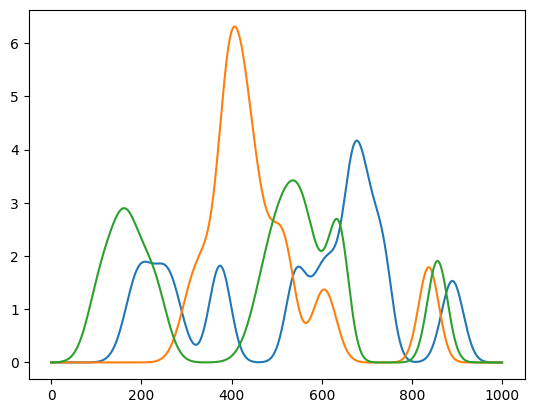

In [3]:
for s in data:
    plt.plot(waves, s)
plt.show()

In [4]:
data = torch.Tensor(data)
weights = torch.Tensor(weights)

torch.Size([1000, 1000])


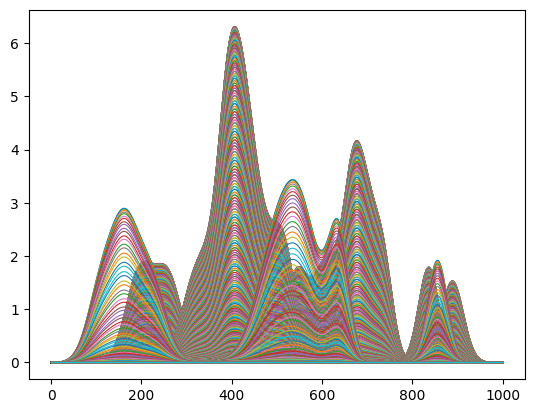

In [5]:
reference_mcr = SimpleMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=weights,
                            preload_spectra=data
                           )
reference_mcr.freeze_spectra()
reference_mcr.freeze_weights()
# Forward pass without additional arguments
observed_data = reference_mcr().detach()
print(observed_data.shape)

for s in observed_data:
    plt.plot(s.detach().numpy(), lw=0.8)
plt.show()



In [6]:
trial1_mcr = SimpleMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            spectra_modifier=nn.Softplus(),
                            preload_weights=weights,
                            preload_spectra=None, 
                           )

trial1_mcr.freeze_weights()



In [7]:
cl = smooth_loss.SmoothLoss(smooth_spectra_weight=0.0, smooth_weight_weight=0.0)

train_mcr_model(
    model=trial1_mcr, 
    observed_data=observed_data, 
    num_epochs=1000, 
    mini_epochs=3, 
    lr=0.01, 
    tolerance=1e-12, 
    optimizer_class=torch.optim.Adam, 
    loss_fn=lambda predicted, target: cl(predicted, 
                                         target, 
                                         trial1_mcr.spectra(), 
                                         trial1_mcr.weights()),  # Passing spectra for smoothness
    device="cpu"
)

Epoch 1/1000, Loss: 0.112989
Epoch 11/1000, Loss: 0.094189
Epoch 21/1000, Loss: 0.077444
Epoch 31/1000, Loss: 0.063139
Epoch 41/1000, Loss: 0.051309
Epoch 51/1000, Loss: 0.041836
Epoch 61/1000, Loss: 0.034098
Epoch 71/1000, Loss: 0.027796
Epoch 81/1000, Loss: 0.022711
Epoch 91/1000, Loss: 0.018563
Epoch 101/1000, Loss: 0.015149
Epoch 111/1000, Loss: 0.012316
Epoch 121/1000, Loss: 0.010017
Epoch 131/1000, Loss: 0.008128
Epoch 141/1000, Loss: 0.006507
Epoch 151/1000, Loss: 0.005159
Epoch 161/1000, Loss: 0.004042
Epoch 171/1000, Loss: 0.003252
Epoch 181/1000, Loss: 0.002823
Epoch 191/1000, Loss: 0.002565
Epoch 201/1000, Loss: 0.002350
Epoch 211/1000, Loss: 0.002165
Epoch 221/1000, Loss: 0.001997
Epoch 231/1000, Loss: 0.001851
Epoch 241/1000, Loss: 0.001721
Epoch 251/1000, Loss: 0.001602
Epoch 261/1000, Loss: 0.001496
Epoch 271/1000, Loss: 0.001399
Epoch 281/1000, Loss: 0.001314
Epoch 291/1000, Loss: 0.001237
Epoch 301/1000, Loss: 0.001161
Epoch 311/1000, Loss: 0.001098
Epoch 321/1000, Los

In [8]:
recovered_spectra = trial1_mcr.spectra().clone()

In [9]:
recovered_weights = trial1_mcr.weights().clone()

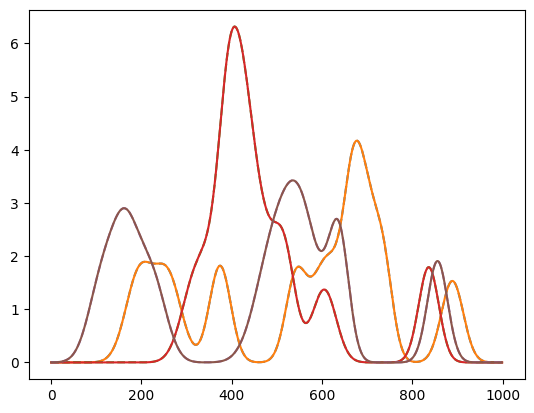

In [10]:
for s, ss in zip(recovered_spectra, data):
    plt.plot(s.detach().cpu().numpy(), '--')
    plt.plot(ss.cpu().numpy(), )

In [11]:
def inverse_softplus(y):
    # Ensure input is a tensor
    y = torch.as_tensor(y)
    # Inverse softplus computation: ln(exp(y) - 1)
    # To maintain numerical stability for very small y values, we use torch.where to avoid log(0).
    return torch.where(y > 1e-4, torch.log(torch.exp(y) - 1), y)
import torch
import torch.nn.functional as F

class ScaledSoftmax(torch.nn.Module):
    def __init__(self, scale=100.0, dim=0):
        super(ScaledSoftmax, self).__init__()
        # Learnable scale parameter, initialized to scale_init
        self.scale = scale
        self.dim = dim

    def forward(self, x):
        # Apply softmax to input x
        softmax_output = F.softmax(x, dim=self.dim)
        # Multiply softmax output by the learnable scaling parameter
        scaled_output = self.scale * softmax_output
        return scaled_output


cl = smooth_loss.SmoothLoss(smooth_spectra_weight=0.0, smooth_weight_weight=0.1)

trial2_mcr = SimpleMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=None,
                            preload_spectra=data,
                            weights_modifier=None,
                           )
trial2_mcr.freeze_spectra()

train_mcr_model(trial2_mcr, 
                observed_data, 
                num_epochs=1000, 
                mini_epochs=10, 
                lr=0.001, 
                tolerance=1e-6, 
                optimizer_class=torch.optim.Adam, 
                loss_fn=lambda predicted, target: cl(predicted, 
                                         target, 
                                         trial2_mcr.spectra(), 
                                         trial2_mcr.weights()), device="cpu")

Epoch 1/1000, Loss: 0.144170
Epoch 11/1000, Loss: 0.118541
Epoch 21/1000, Loss: 0.095935
Epoch 31/1000, Loss: 0.075816
Epoch 41/1000, Loss: 0.057480
Epoch 51/1000, Loss: 0.040833
Epoch 61/1000, Loss: 0.025813
Epoch 71/1000, Loss: 0.012960
Epoch 81/1000, Loss: 0.003937
Epoch 91/1000, Loss: 0.000356
Epoch 101/1000, Loss: 0.000067
Early stopping: Loss change below tolerance.


In [12]:
recovered_weights = trial2_mcr.weights().clone()

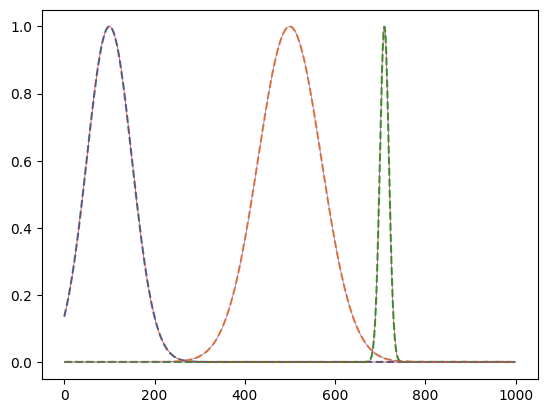

In [13]:
t = np.arange(100)
plt.plot(recovered_weights[:,0].detach().cpu().numpy(), "--", )
plt.plot(recovered_weights[:,1].detach().cpu().numpy(), "--")
plt.plot(recovered_weights[:,2].detach().cpu().numpy(), "--")
plt.plot(weights[:,0].detach().cpu().numpy(), lw=.5)
plt.plot(weights[:,1].detach().cpu().numpy(), lw=.5)
plt.plot(weights[:,2].detach().cpu().numpy(), lw=.5)


In [14]:
from torchmcr.spectrainit import simplisma

In [51]:
start_spectra = simplisma(observed_data, 3)

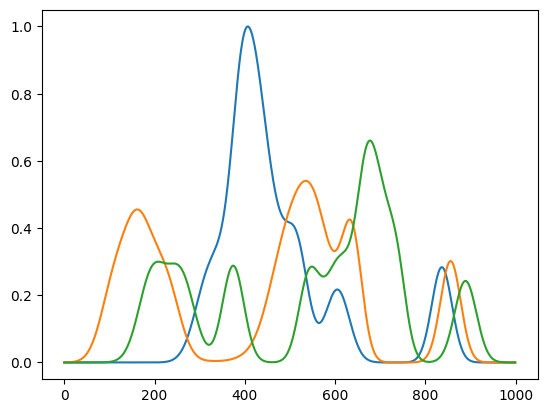

In [52]:
plt.plot(start_spectra[0])
plt.plot(start_spectra[1])
plt.plot(start_spectra[2])
plt.show()

In [67]:
trial3_mcr = SimpleMCRModel(M_samples=weights.shape[0], 
                            K_components=3, 
                            N_waves=data.shape[-1],
                            preload_weights=None,
                            preload_spectra=inverse_softplus(start_spectra),
                            spectra_modifier=torch.nn.Softplus(), 
                            weights_modifier=torch.nn.Softplus())


In [68]:
cl = smooth_loss.SmoothLoss(smooth_spectra_weight=0.4, smooth_weight_weight=0.2, weight_cross_product_weight=.1)

train_mcr_model(trial3_mcr, observed_data, num_epochs=1000, mini_epochs=5, lr=0.01, tolerance=1e-12, 
                    optimizer_class=torch.optim.Adam, loss_fn=lambda predicted, target: cl(predicted, 
                                         target, 
                                         trial3_mcr.spectra(), 
                                         trial3_mcr.weights()), device="cpu")


Epoch 1/1000, Loss: 0.114877
Epoch 11/1000, Loss: 0.088801
Epoch 21/1000, Loss: 0.075425
Epoch 31/1000, Loss: 0.066087
Epoch 41/1000, Loss: 0.057622
Epoch 51/1000, Loss: 0.049153
Epoch 61/1000, Loss: 0.040400
Epoch 71/1000, Loss: 0.031981
Epoch 81/1000, Loss: 0.025072
Epoch 91/1000, Loss: 0.019310
Epoch 101/1000, Loss: 0.014677
Epoch 111/1000, Loss: 0.011448
Epoch 121/1000, Loss: 0.009205
Epoch 131/1000, Loss: 0.007792
Epoch 141/1000, Loss: 0.006770
Epoch 151/1000, Loss: 0.005994
Epoch 161/1000, Loss: 0.005492
Epoch 171/1000, Loss: 0.005171
Epoch 181/1000, Loss: 0.004925
Epoch 191/1000, Loss: 0.004716
Epoch 201/1000, Loss: 0.004539
Epoch 211/1000, Loss: 0.004370
Epoch 221/1000, Loss: 0.004230
Epoch 231/1000, Loss: 0.004105
Epoch 241/1000, Loss: 0.004006
Epoch 251/1000, Loss: 0.003902
Epoch 261/1000, Loss: 0.003816
Epoch 271/1000, Loss: 0.003743
Epoch 281/1000, Loss: 0.003669
Epoch 291/1000, Loss: 0.003601
Epoch 301/1000, Loss: 0.003543
Epoch 311/1000, Loss: 0.003491
Epoch 321/1000, Los

In [69]:
with torch.no_grad():
    www = trial3_mcr.weights.forward().clone().cpu().numpy()
    sss = trial3_mcr.spectra.forward().clone().cpu().numpy()
    
    

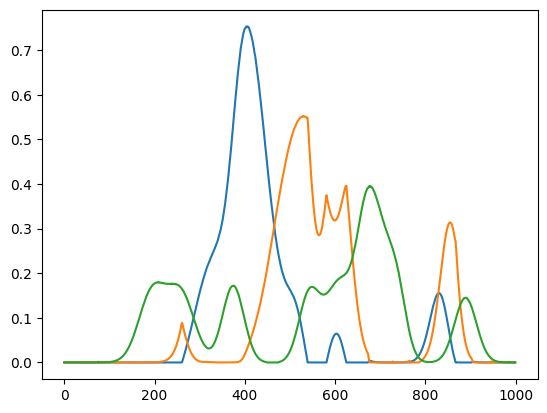

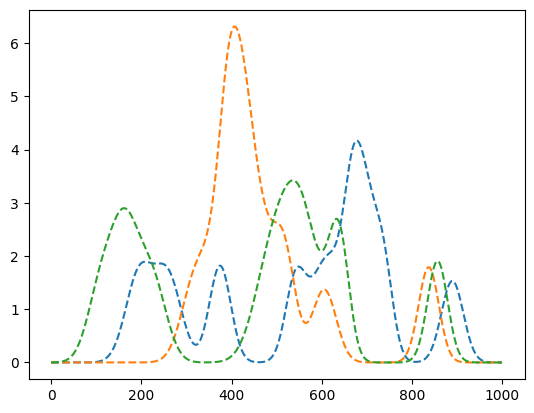

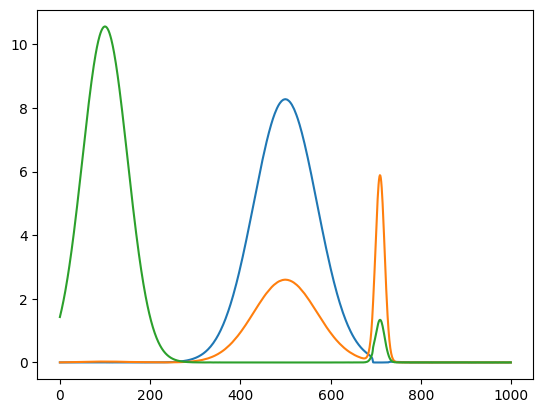

In [70]:
plt.plot(sss[0,...])
plt.plot(sss[1,...])
plt.plot(sss[2,...])
plt.show()
for s in data:
    plt.plot(waves, s, '--')
plt.show()

plt.plot(www[:,0])
plt.plot(www[:,1])
plt.plot(www[:,2])

plt.show()
